In [1]:
import datetime
import sys
sys.path.append("..")
import random
from numpy.random import default_rng
from annoy import AnnoyIndex
import torch.autograd as autograd
from typing import List
import anndata
from functools import partial
from copy import deepcopy

from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from sklearn.metrics import (adjusted_rand_score, calinski_harabasz_score,
                             normalized_mutual_info_score, silhouette_score)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing

import utils
from sklearn import metrics
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from random import sample
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import scanpy as sc
import colorcet as cc
import time
import os
from scipy import sparse

from utils.explanation_utils import explanation_hook, get_explanation

torch.cuda.set_device(2)

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
path= "../"

# check available files
# !ls ../real_data

torch.autograd.set_detect_anomaly(True)

In [2]:
sc.__version__

'1.9.3'

In [3]:
# select dataset to analyze
# dataset = "10X_PBMC"

# filtered_matrix_h5 = f"{path}real_data/{dataset}.h5"
# filtered_feature_bc_matrix = get_matrix_from_h5(filtered_matrix_h5)

# dataset = "pancreas"
# adata = sc.read('data/%s.h5ad' % (dataset), backup_url='https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1')

adata = sc.read_loom("seurat_simulation_1.loom")

# for getting gene name for the seurat data
adata_2 = sc.read_h5ad("genex_simulation_1.h5ad")

# adata = sc.read_h5ad('data/%s.h5ad' % (dataset), backed = 'r')
# adata = sc.read_h5ad('data/GTEx_8_tissues_snRNAseq_atlas_071421.public_obs.h5ad')
batch_str = "Batch"

adata

/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/rom/minicond

AnnData object with n_obs × n_vars = 8000 × 5000
    obs: 'Batch', 'Group', 'nCount_RNA', 'nFeature_RNA', 'orig.ident'

In [4]:
adata = adata[adata_2.obs.index, adata_2.var.index]

In [5]:
adata.obs

,Batch,Group,nCount_RNA,nFeature_RNA,orig.ident
CellID,,,,,
Cell1,Batch1,Group1,42111.0,378,mydata_scRNAseq
Cell2,Batch1,Group2,17649.0,229,mydata_scRNAseq
Cell3,Batch1,Group1,32522.0,345,mydata_scRNAseq
Cell4,Batch1,Group1,22980.0,261,mydata_scRNAseq
Cell5,Batch1,Group1,15843.0,217,mydata_scRNAseq
...,...,...,...,...,...
Cell7995,Batch4,Group1,27576.0,287,mydata_scRNAseq
Cell7997,Batch4,Group1,42086.0,344,mydata_scRNAseq
Cell7998,Batch4,Group1,37344.0,331,mydata_scRNAseq


In [6]:
# adata_2.var.index

In [7]:
# adata.var.index = adata_2.var.index

In [8]:
adata

View of AnnData object with n_obs × n_vars = 7891 × 4695
    obs: 'Batch', 'Group', 'nCount_RNA', 'nFeature_RNA', 'orig.ident'

In [9]:
# output_results = adata.X

max_val = np.amax(adata.X.toarray())
min_val = np.amin(adata.X.toarray())

print("Upper bound of the gene expression: ", max_val)
print("Lower bound of the gene expression: ", min_val)

Upper bound of the gene expression:  8.159649
Lower bound of the gene expression:  -5.0629086


In [10]:
# le = preprocessing.LabelEncoder()
# new_batch = le.fit_transform(adata.obs.Batch)

# new_batch = [str(each) for each in new_batch]

# adata.obs.Batch = new_batch

In [11]:
import scanpy as sc
import pandas as pd
import seaborn as sns

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 1
sc.settings.set_figure_params(
    dpi=200, frameon=False, figsize=(3, 3), facecolor='white')

# adata.X = sc.pp.normalize_per_cell(adata.X, copy = True, counts_per_cell_after=1e4, min_counts=0)
# adata.X = sc.pp.log1p(adata.X)
# # observer batch effect
# sc.pp.scale(adata)
# sc.pp.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)

# sc.pl.umap(adata, color=['Batch', 'celltype'],
#            palette=sc.pl.palettes.vega_20_scanpy)


In [12]:
# sc.tl.umap(adata)

# sc.pl.umap(adata, color=["Group"],
#            palette=sc.pl.palettes.vega_20_scanpy)

In [13]:
# sc.pl.umap(adata, color=['tissue'],
#            palette=sc.pl.palettes.vega_20_scanpy)


In [14]:
# G_AB.eval()
# with torch.no_grad():
#     imgs = Variable(FloatTensor(scd.X))
# #         select batch for anchoring

#     labels_ = [0.0]

#     for each in range(c_dim - 1):
#         labels_.append(0.0)

#     labels_ = np.array(labels_)

#     labels_ = np.tile(labels_, (scd.X.shape[0], 1))

#     labels = Variable(FloatTensor(labels_))

#     labels[:, anchor_index] = 1.0

# #     labels = Variable(FloatTensor(scd.labels))

#     groups = Variable(FloatTensor(scd.groups))

#     static_sample = G_AB(imgs, labels)
#     fake_data = static_sample.cpu().detach().numpy()  # pseudo-cell expression vector
    
# output_results = fake_data

In [15]:
output_results = adata.X.toarray()

In [16]:
from sklearn.decomposition import PCA

adata.obsm["X_latent"] = output_results

# output_results_norm = sc.pp.normalize_per_cell(output_results, counts_per_cell_after = 1e4, copy = True)
# output_results_log_norm = sc.pp.log1p(output_results_norm)
# output_results_scaled = sc.pp.scale(output_results_log_norm)
# output_results_scaled = sc.pp.scale(output_results, copy = True)

# adata.obsm["X_latent_norm"] = output_results_log_norm
# adata.obsm["X_latent_scaled"] = output_results_scaled.copy()

pca = PCA(n_components = 50, random_state = 8)

# pca.fit(sc.pp.scale(adata.obsm["X_latent"], copy = True))

# X_pca = pca.transform(sc.pp.scale(adata.obsm["X_latent"], copy = True))

pca.fit(adata.obsm["X_latent"])

X_pca = pca.transform(adata.obsm["X_latent"])

adata.obsm["X_pca"] = X_pca

In [17]:
output_results.shape

(7891, 4695)

In [18]:
adata.obs["Batch"] = [str(each) for each in list(adata.obs["Batch"].values)]

In [19]:
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=30)
# sc.external.pp.bbknn(adata_all, batch_key='batch', use_rep='X_latent')
sc.tl.umap(adata, method = "rapids")

/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/umap/distances.

In [20]:
custom_palette = cc.glasbey_category10

/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


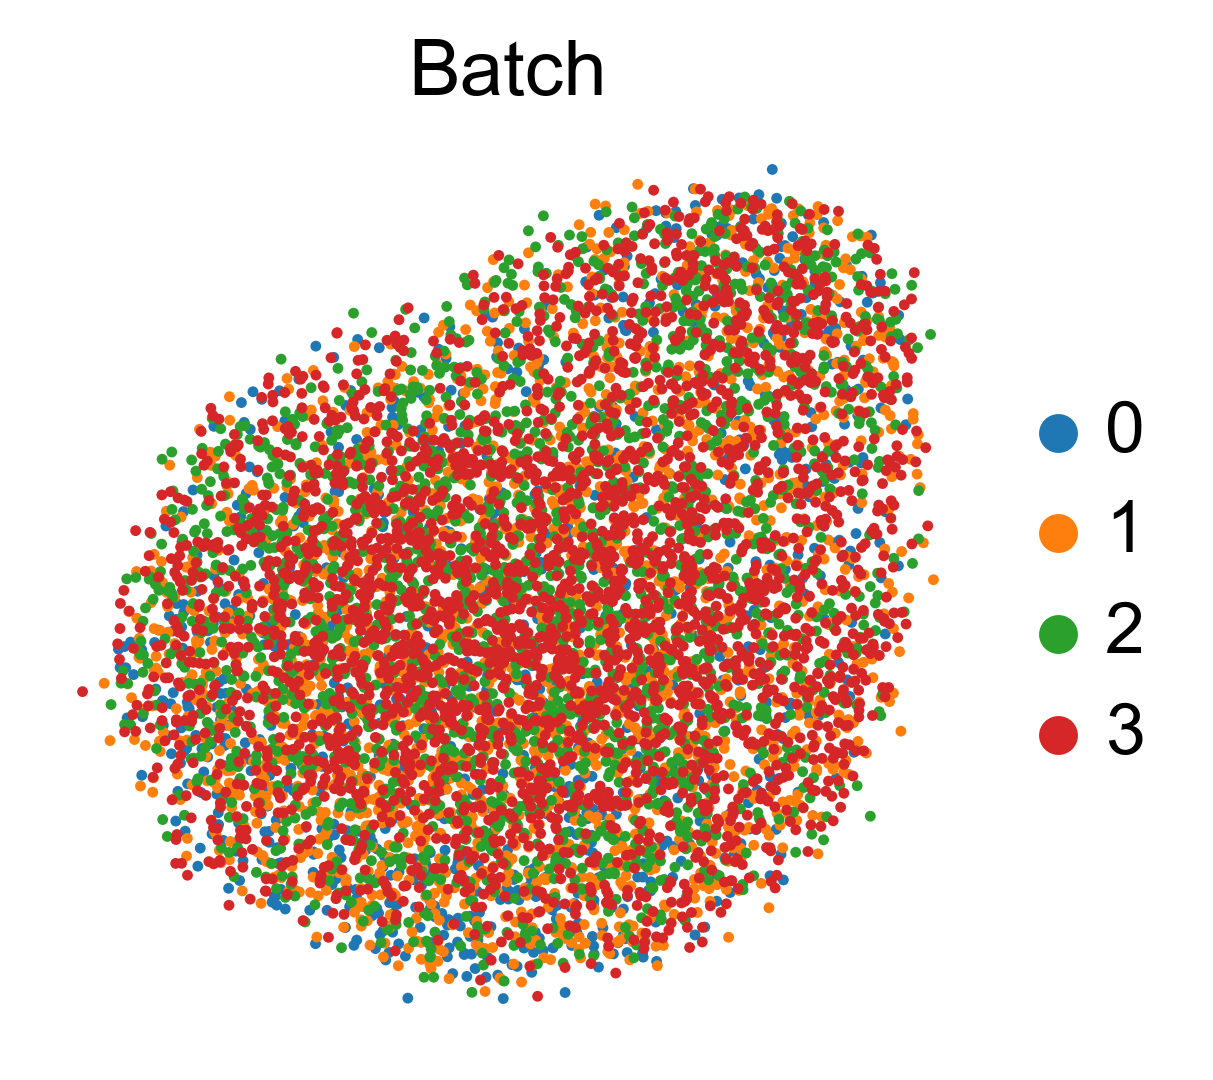

In [21]:
adata.obs["Batch"] = adata.obs["Batch"].astype('category')
adata.obs["Batch"].cat.categories = adata_2.obs["Batch"].cat.categories
sc.pl.umap(adata, color=["Batch"],
           palette=custom_palette)

/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


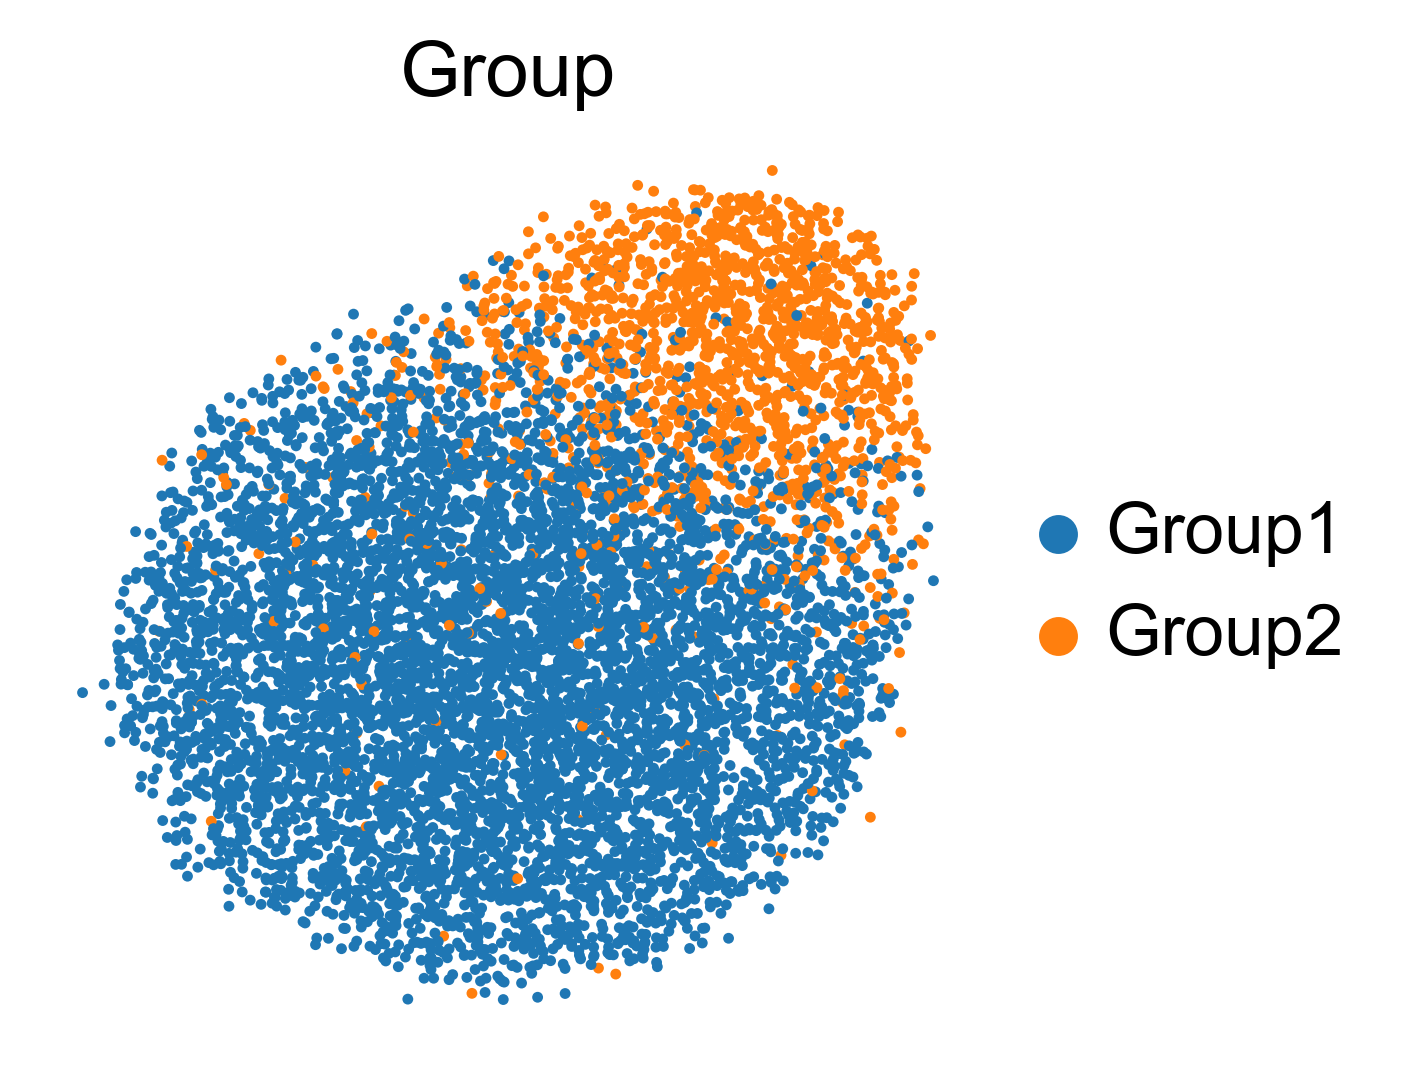

In [22]:
adata.obs["Group"] = adata.obs["Group"].astype('category')
adata.obs["Group"].cat.categories = adata_2.obs["Group_num"].cat.categories
sc.pl.umap(adata, color=["Group"],
           palette=custom_palette)

In [23]:
import scipy.special
from sklearn.metrics.cluster import adjusted_rand_score


def ari(adata, group1, group2, implementation="sklearn"):
    """Adjusted Rand Index
    The function is symmetric, so group1 and group2 can be switched
    For single cell integration evaluation the comparison is between predicted cluster
    assignments and the ground truth (e.g. cell type)
    :param adata: anndata object
    :param group1: string of column in adata.obs containing labels
    :param group2: string of column in adata.obs containing labels
    :param implementation: if set to 'sklearn', uses sklearn's implementation,
        otherwise native implementation is taken
    """

    group1 = adata.obs[group1].to_numpy()
    group2 = adata.obs[group2].to_numpy()

    if len(group1) != len(group2):
        raise ValueError(
            f"different lengths in group1 ({len(group1)}) and group2 ({len(group2)})"
        )

    return adjusted_rand_score(group1, group2)

def compute_ari(adata):

    resolutions = None

    if resolutions is None:
        n = 20
        resolutions = [2 * x / n for x in range(1, n + 1)]

    score_max = 0
    res_max = resolutions[0]
    clustering = None
    score_all = []
    use_rep = "X_pca"
    cluster_key = "louvain"
    label_key = "Group"
    sc.pp.neighbors(adata, use_rep=use_rep)

    for res in resolutions:
        sc.tl.louvain(adata, resolution=res, key_added=cluster_key)
        score = ari(adata, label_key, cluster_key)
        score_all.append(score)
        if score_max < score:
            score_max = score
            res_max = res
            clustering = adata.obs[cluster_key]

    return score_max

In [24]:
adata

AnnData object with n_obs × n_vars = 7891 × 4695
    obs: 'Batch', 'Group', 'nCount_RNA', 'nFeature_RNA', 'orig.ident'
    uns: 'neighbors', 'umap', 'Batch_colors', 'Group_colors'
    obsm: 'X_latent', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [25]:
compute_ari(adata)

0.7276206398981391

In [26]:
adata.write_h5ad("seurat_simulation_1.h5ad")

In [27]:
# clear GPU
import torch
torch.cuda.empty_cache()